In [31]:
import os
import sys
import pdb
import time
import glob
import functools
import multiprocessing
import numpy as np
import soundfile as sf
import scipy.interpolate
import scipy.io
import scipy.signal
import h5py
import tqdm
import soxr
import importlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import IPython.display as ipd

sys.path.append("/om2/user/msaddler/python-packages/msutil")
import util_figures
import util_stimuli
import util_misc

import simulator
importlib.reload(simulator)


<module 'simulator' from '/rdma/vast-rdma/vast/mcdermott/msaddler/python-packages/virtual_acoustic_room/simulator.py'>

In [32]:
importlib.reload(simulator)

room_materials = [26] * 6
room_dim_xyz = [30, 30, 30]
head_pos_xyz = [15, 15, 15]
head_azim = 175
src_azim = 90
src_elev = 0
src_dist = 1.4
buffer = 0.5

c = 344.5
buffer = 0
sr = 44100
dur = 0.5
use_hrtf_symmetry = True
use_highpass = True
use_jitter = False
incorporate_lead_zeros = True
use_log_distance = True
hrtf_locs = None
hrtf_firs = None

np.random.seed(0)
brir = simulator.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    c=c,
    dur=dur,
    hrtf_locs=hrtf_locs,
    hrtf_firs=hrtf_firs,
    use_hrtf_symmetry=use_hrtf_symmetry,
    use_log_distance=use_log_distance,
    use_jitter=use_jitter,
    use_highpass=use_highpass,
    incorporate_lead_zeros=incorporate_lead_zeros,
    processes=12,
    strict=False,
    verbose=True,
)


[get_brir] loaded kemar_hrtfs (Gardner & Martin, 1994): (368, 128, 2)
[get_brir] head_pos: [15, 15, 15], src_pos: [14.877981960153278, 13.605327422671557, 15.0], room_dim: [30, 30, 30]
[get_brir] time elapsed: 0.34230709075927734 seconds
[get_brir] incorporated 0 leading zeros


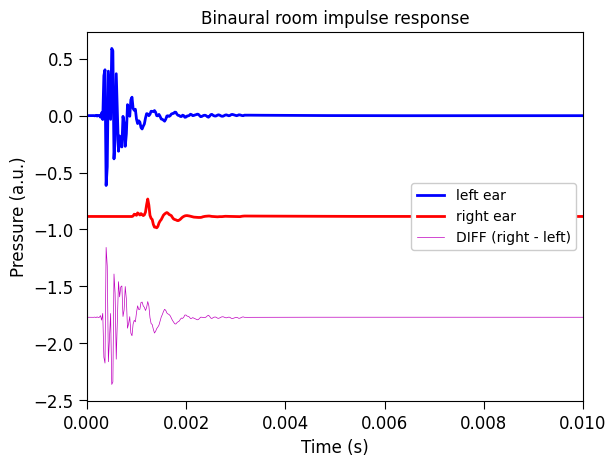

In [33]:
# fig, ax = plt.subplots()
# offset = brir.max() * 1.5
# t = np.arange(0, brir.shape[0]) / sr
# ax.plot(t, brir[:, 0] + 0 * offset, color="b")
# ax.plot(t, brir[:, 1] + 1 * offset, color="r")
# ax.plot(t, brir[:, 1] - brir[:, 0] + 2 * offset, color="m")
# util_figures.format_axes(
#     ax,
#     xlimits=[0, 0.01],
# )
# plt.show()

fig, ax = plt.subplots()
offset = brir.max() * 1.5
t = np.arange(0, brir.shape[0]) / sr
ax.plot(t, brir[:, 0] - 0 * offset, color="b", label="left ear", lw=2)
ax.plot(t, brir[:, 1] - 1 * offset, color="r", label="right ear", lw=2)
ax.plot(t, brir[:, 1] - brir[:, 0] - 2 * offset, color="m", label="DIFF (right - left)", lw=1/2)
util_figures.format_axes(
    ax,
    xlimits=[0, 0.01],
    str_xlabel="Time (s)",
    str_ylabel="Pressure (a.u.)",
    str_title="Binaural room impulse response",
)
ax.legend(loc="center right", framealpha=1)
plt.show()


In [34]:
t = np.arange(0, 2, 1 / sr)
y = np.random.randn(*t.shape)
y = (np.sin(2 * np.pi * 2 * t) > 0) * y

# print(f"Example audio: (shape={y.shape}, sr={sr})")
# ipd.display(ipd.Audio(rate=sr, data=y))

y_spatialized = util_stimuli.spatialize_sound(y, brir)
print(f"Example audio: (shape={y_spatialized.shape}, sr={sr})")
ipd.display(ipd.Audio(rate=sr, data=y_spatialized.T, normalize=True))


Example audio: (shape=(88200, 2), sr=44100)


In [35]:
meas_locs = np.load('kemar_hrtfs/hrtfs.npz')['hrtf_locs']
meas_files = []
for elev in np.arange(-40, 91, 10, dtype=int):
    meas_files.extend(sorted(glob.glob(f'kemar_hrtfs/elev{elev}/*wav')))

scipy.io.savemat("kemar_hrtfs/hrtfs.mat", {"meas_locs": meas_locs, "meas_files": meas_files})


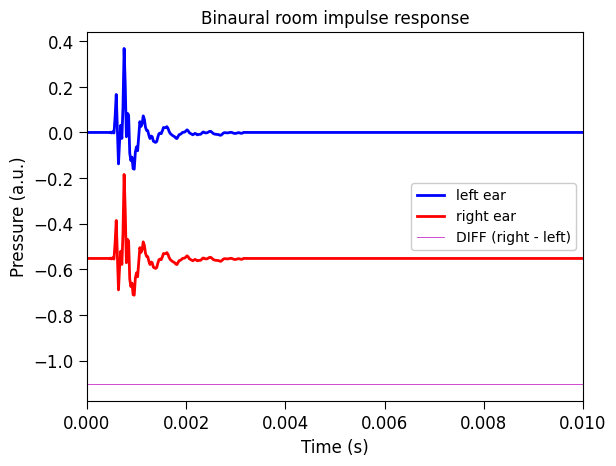

In [36]:
brir, sr = sf.read("tmp.wav")

fig, ax = plt.subplots()
offset = brir.max() * 1.5
t = np.arange(0, brir.shape[0]) / sr
ax.plot(t, brir[:, 0] - 0 * offset, color="b", label="left ear", lw=2)
ax.plot(t, brir[:, 1] - 1 * offset, color="r", label="right ear", lw=2)
ax.plot(t, brir[:, 1] - brir[:, 0] - 2 * offset, color="m", label="DIFF (right - left)", lw=1/2)
util_figures.format_axes(
    ax,
    xlimits=[0, 0.01],
    str_xlabel="Time (s)",
    str_ylabel="Pressure (a.u.)",
    str_title="Binaural room impulse response",
)
ax.legend(loc="center right", framealpha=1)
plt.show()
